# Stock Price Prediction With LSTM
This notebook describe the process of future stock price prediction using LSTM.
The process is devided into: 
Part 0 - Data Analysing; 
Part 1 - Data Preprocessing; 
Part 2 - Building the LSTM model; 
Part 3 - Making the prediction and visualising the results 

## Part 0 - Data Analysing

### Importing the libraries

In [440]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import seaborn as sns
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

%matplotlib inline

### Downloading the stock price history of several companies taking into account the last 3 years

In [235]:
# parameters
companies = ['GOOG', 'AMZN', 'MSFT', 'AAPL','TSLA', 'EBAY', 'PETR4.SA', 'Vale', 'MGLU3.SA'] 
timerange_years = 3
end_date = datetime.now()

# Downloading the dataset
def download_stockdata(companies, timerange_years, end_date):
    start_date = end_date - timedelta(days=timerange_years*365)
    yf.pdr_override()
    df_companies = pdr.get_data_yahoo(companies, start=start_date, end=end_date)
    return df_companies
    

df_companies = download_stockdata(companies, timerange_years, end_date)

[*********************100%***********************]  9 of 9 completed


### Visualizing the close stock price history of all companies

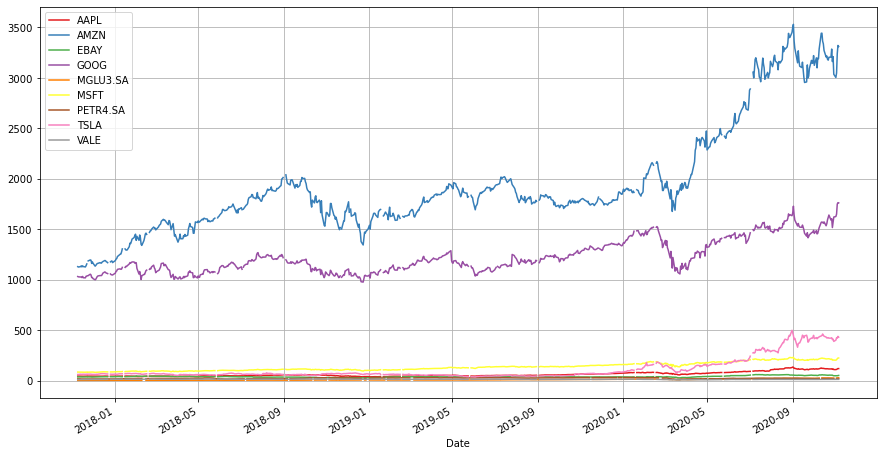

In [247]:
df_companies.Close.plot(figsize=(15, 8), grid=True, colormap='Set1')

### Analyzing the correlation between the data

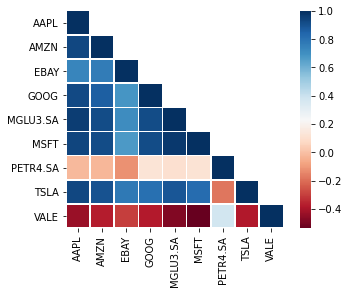

In [242]:
# Calculating the correlation
corr = df_companies.Close.corr()

# Ploting the results
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(corr, mask=mask, cmap='RdBu', square=True, linewidths=.5)

### Looking better to Tesla dataset 

[*********************100%***********************]  1 of 1 completed


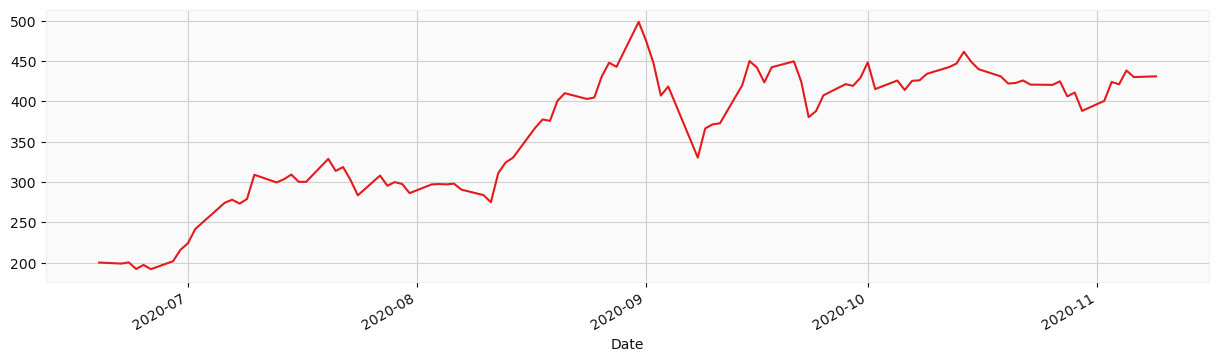

In [521]:
# parameters
companies = ['TSLA'] 
timerange_years = 3
end_date = datetime.now()

# dowwnloading Tesla dataset
df_tesla = download_stockdata(companies, timerange_years, end_date)

#Visualizing the data 
df_tesla.ta.Close.plot(figsize=(15, 4), grid=True, colormap='Set1')

### Calculating the Relative Strength Index (RSI)

In [525]:
# Funtion to calculate the Relative Strength Index (RSI) 
def calculateRSI (data, time_window):
    # calculating the difference of between a item and the last one
    diff = data.diff(1).dropna() # exclude the first value (witch is na)

    # Initializing the up_change and down_change variables preserving the sign of diff values
    up_change = 0 * diff
    down_change = 0 * diff
    
    # up change is equal to the positive difference, otherwise it is still equal to zero
    up_change[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative difference, otherwise it is still equal to zero
    down_change[diff < 0] = diff[ diff < 0 ]
    
    # Calculating the exponential moving average considering the last "time_window" timesteps
    # 'com'value is related to exponential decay. We set com=time_window-1 to get decay alpha=1/time_window
    up_change_avg = up_change.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_change_avg = down_change.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    # Calculating the Relative Strength Index (RSI) 
    rs = abs(up_change_avg/down_change_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

df_tesla['RSI'] = calculateRSI(df_tesla['Close'], time_window = 14)
df_tesla.tail()

,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2020-11-03,409.730011,427.769989,406.690002,423.899994,423.899994,34351700,51.755163
2020-11-04,430.619995,435.399994,417.100006,420.980011,420.980011,32143100,50.821535
2020-11-05,428.299988,440.000000,424.000000,438.089996,438.089996,28414500,55.847605
2020-11-06,436.100006,436.570007,424.279999,429.950012,429.950012,21653600,53.068841
2020-11-09,439.500000,452.500000,427.760010,430.945007,430.945007,29734977,53.374231


### Ploting RSI values and significant levels

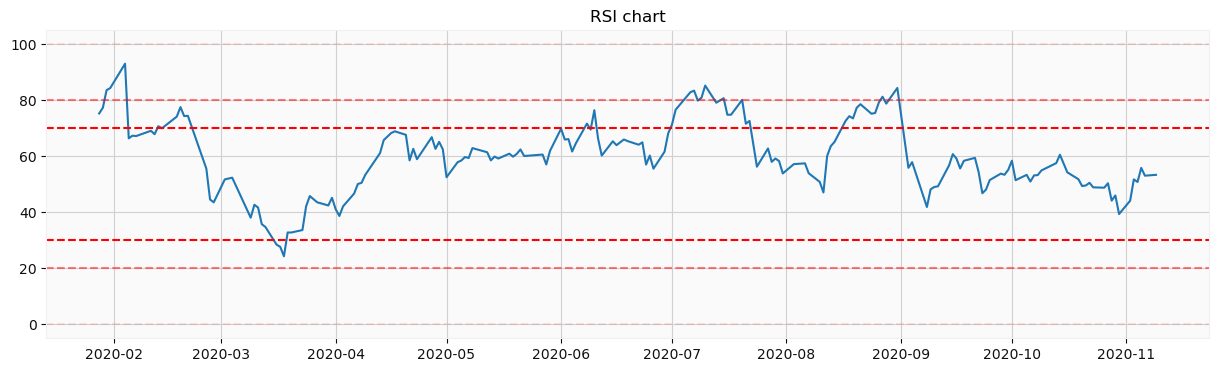

In [526]:
# ploting RSI values
plt.figure(figsize=(15,4))
plt.title('RSI chart')
plt.plot(df_tesla['RSI'].tail(200))

# ploting significant levels
plt.axhline(0, linestyle='--', alpha=0.1, color = 'red')
plt.axhline(20, linestyle='--', alpha=0.5, color = 'red')
plt.axhline(30, linestyle='--', color = 'red')

plt.axhline(70, linestyle='--', color = 'red')
plt.axhline(80, linestyle='--', alpha=0.5, color = 'red')
plt.axhline(100, linestyle='--', alpha=0.1, color = 'red')
plt.show()

### Analyzing the moving mean behavior taking into account the last 10, 20 and 50 days

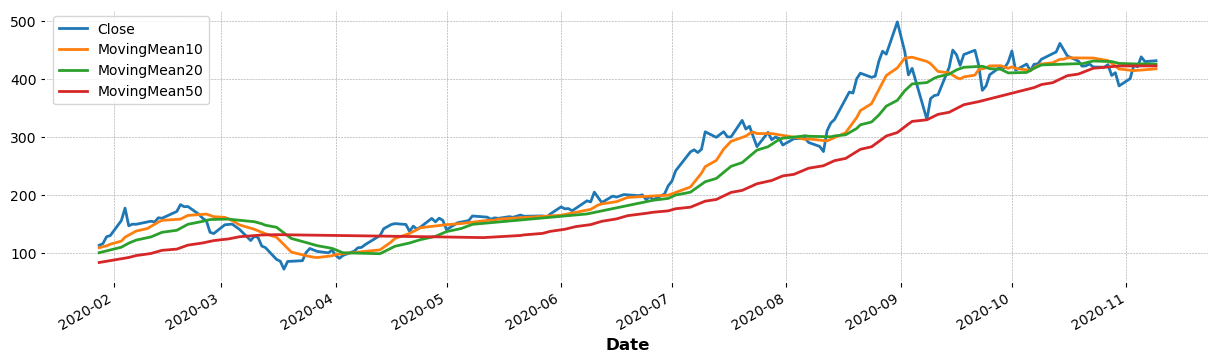

In [487]:
# Add a column into the dataset with the moving mean taking into account the last x days
def calculateMovingAverage(df_data, rollingDays):
    movingAverage = df_data.Close.rolling(rollingDays).mean()
    #df_stock_data['MovingMean' + str(rollingDays)] = df_stock_data.Close.rolling(rollingDays).mean()
    return movingAverage

# Add column with the moving mean of the last 10 days  
df_tesla['MovingMean10'] = calculateMovingAverage(df_tesla, 10)

# Add column with the moving mean of the last 20 days
df_tesla['MovingMean20'] = calculateMovingAverage(df_tesla, 20)

# Add column with the moving mean of the last 50 days
df_tesla['MovingMean50'] = calculateMovingAverage(df_tesla, 50)

#Plotting the data
columns = ['Close','MovingMean10', 'MovingMean20', 'MovingMean50']
df_tesla[columns].tail(200).plot(figsize=(15, 4), grid=True)

### Plotting candlestick; moving averages considering 5,10, and 20 timestpes; and volume

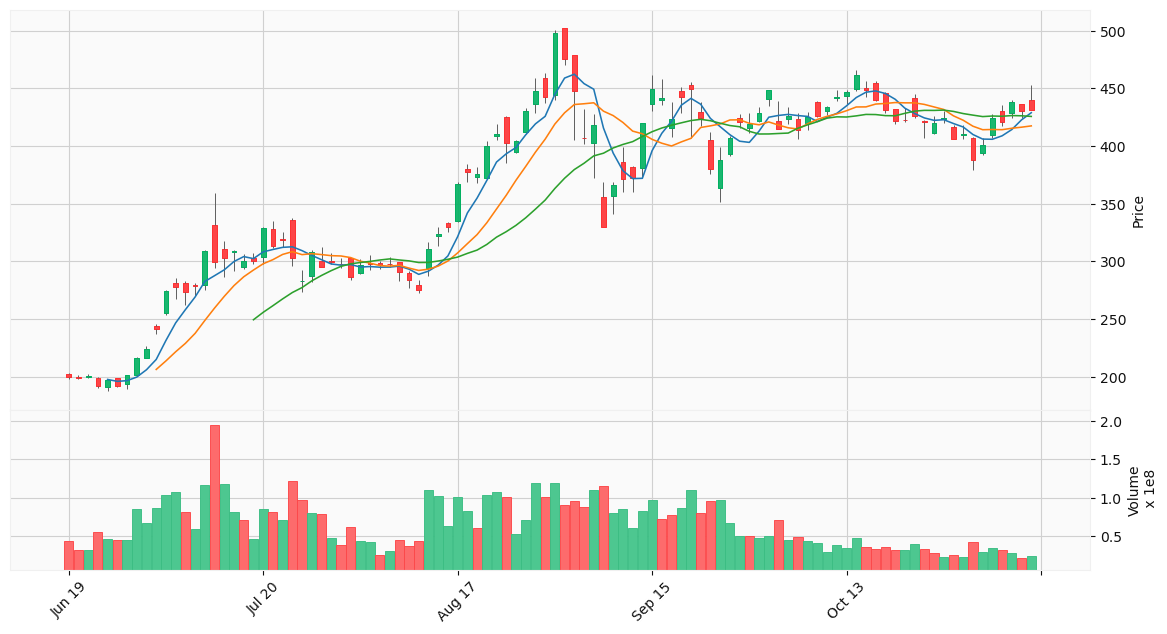

In [520]:
import mplfinance as mpf

# convert the index to datetime
df_tesla.index = pd.to_datetime(df_tesla.index)
    
# Plotting candlestick; moving averages considering 5,10, and 20 timestpes; and volume
mpf.plot(df_tesla.tail(100), type='candle', style='yahoo',
            #title='S&P 500, Nov 2019',
            ylabel='Price',
            ylabel_lower='Volume',
            mav=(5,10,20),
            volume = True,
            figsize=(15, 8))

### Analyzing the behavior percent daily return

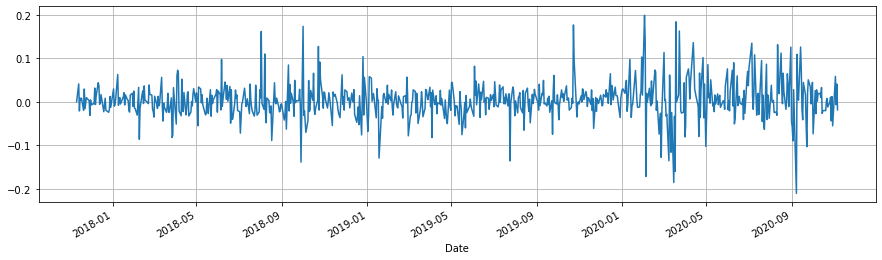

In [253]:
# Function to add a column into the dataset with the percent daily return
def addDailyReturn(df_stock_data):
    df_stock_data['DailyReturn'] = df_stock_data.Close.pct_change()
    
# Add a column into the dataset with the percent daily return
addDailyReturn(df_tesla)

# Plotting the data
df_tesla.DailyReturn.plot(figsize=(15, 4), grid=True)

Visualizing the distribution of percent daily return

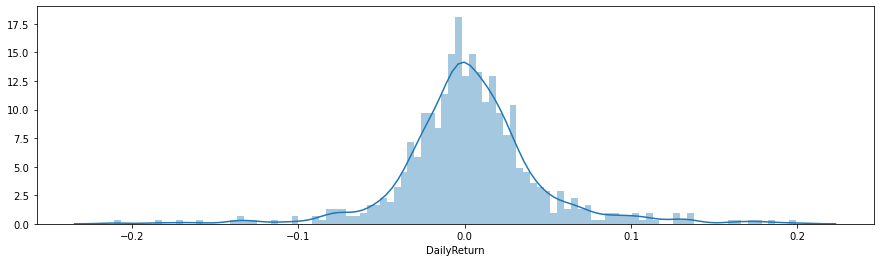

In [265]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
sns.distplot(df_tesla.DailyReturn.dropna(), bins=100, ax=ax1)

In [456]:
import matplotlib.dates as mdates
df_tesla.reset_index(inplace=True)
df_tesla['DateAsNumber'] = df_tesla.Date.apply(mdates.date2num)

Text(0.5, 6.79999999999999, 'Date')

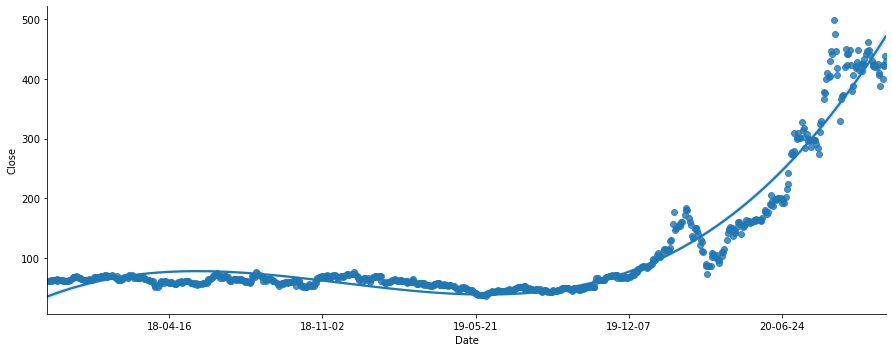

In [126]:
lm = sns.lmplot('DateAsNumber', 'Close', data=df_tesla, aspect=2.5, order=3)
lm.ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
lm.ax.set_xlabel('Date')

# Part 1 - Data Preprocessing

### Dowwnloading Tesla stock price history of the last 5 years

In [274]:
df_tesla = download_stockdata(companies = ['TSLA'], timerange_years = 5, end_date = datetime.now())
df_tesla.tail()

[*********************100%***********************]  1 of 1 completed
Total dataset shape: (1257, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-02,394.000000,406.980011,392.299988,400.510010,400.510010,29021100
2020-11-03,409.730011,427.769989,406.690002,423.899994,423.899994,34351700
2020-11-04,430.619995,435.399994,417.100006,420.980011,420.980011,32143100
2020-11-05,428.299988,440.000000,424.000000,438.089996,438.089996,28414500
2020-11-06,436.100006,436.570007,424.279999,429.950012,429.950012,21653600


### Splitting the dataset into training_set and testing_set

In [277]:
# parameters
timesteps =  60
train_percentage = 0.8
columns = ['Close']

# function to split the dataset into training and testing set
def split_timeserie_train_test(dataset, train_percentage, timesteps):
    
    # Training set with the proportion specified
    training_set = dataset.iloc[:int(dataset.shape[0] * train_percentage)]
    
    # Testing set with the oposit training proportion plus the timesteps needed to the firts prediction
    testing_set_with_timesteps = dataset.iloc[int(dataset.shape[0] * train_percentage)-timesteps:]
    
    return training_set, testing_set_with_timesteps

training_set, testing_set = split_timeserie_train_test(df_tesla[columns], train_percentage, timesteps)

print('Total dataset shape: ' + str(df_tesla.shape))
print('Training set shape: ' + str(training_set.shape))
print('Testing set shape: ' + str(testing_set.shape))


Total dataset shape: (1257, 6)
Training set shape: (1005, 1)
Testing set shape: (312, 1)


### Scalling the data

In [284]:
# Feature Scalling 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

print('Trainning set scaled: ')
print(training_set_scaled)

Trainning set scaled: 
[[0.31247674]
 [0.28703439]
 [0.26320806]
 ...
 [0.71913978]
 [0.75792488]
 [0.79505246]]


### Creating X data structure considering the timesteps and Y considering the days ahead to predict 

In [290]:
# Parameters
days_ahead =  5
timesteps =  60

#creating train and test data structure with defined timesteps and outputs 
def split_timeserie_x_y(training_set, testing_set, timesteps, days_ahead):
    
    # initializing the variables
    x_train, y_train, x_test, y_test = [], [], [], [] 
    
    #x_train = []
    #y_train = []
    #x_test = []
    #y_test = []
    
    # Creating a training data structure with defined timesteps
    for i in range(timesteps, training_set.shape[0]-days_ahead):
        x_train.append(training_set[i-timesteps:i,0])
        y_train.append(training_set[i:i+days_ahead,0])
        
    # Creating a testing data structure with defined days_ahead        
    for i in range(timesteps, testing_set.shape[0]-days_ahead):   
        x_test.append(testing_set[i-timesteps:i,0])
        y_test.append(testing_set[i:i+days_ahead,0])

    # transforming to np.array
    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    
    return x_train, y_train, x_test, y_test
    
    
x_train, y_train, x_test, y_test = split_timeserie_x_y(training_set_scaled, testing_set_scaled, timesteps, days_ahead)

# printing the shapes
print('x_train shape:' + str(x_train.shape))
print('y_train shape:' + str(y_train.shape))
print('x_test shape:' + str(x_test.shape))
print('y_test shape:' + str(y_test.shape))

x_train shape:(940, 60)
y_train shape:(940, 5)
x_test shape:(247, 60)
y_test shape:(247, 5)


### Reshaping the data to Keras

In [291]:
#Reshaping to Keras
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

# printing the shapes
print('x_train shape:' + str(x_train.shape))
print('y_train shape:' + str(y_train.shape))
print('x_test shape:' + str(x_test.shape))
print('y_test shape:' + str(y_test.shape))

x_train shape:(940, 60, 1)
y_train shape:(940, 5, 1)
x_test shape:(247, 60, 1)
y_test shape:(247, 5, 1)


## Part 2 - Building the LSTM model

### Importing the libraries

In [292]:
import tensorflow as tf
import keras as kr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Building the LSTM architecture

In [359]:
# parameters
units_firs = 50
units_headen = 50
units_output = days_ahead
dropout_percentage = 0.2

# Building the LSTM architecture with four headen layers
def create_LSTM_architecture(units_firs, units_headen, units_output, dropout_percentage):

    # Initialising the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = units_firs, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    regressor.add(Dropout(dropout_percentage))

    # Adding the second LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = units_headen, return_sequences = True))
    regressor.add(Dropout(dropout_percentage))

    # Adding the third LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = units_headen, return_sequences = True))
    regressor.add(Dropout(dropout_percentage))

    # Adding the fourth LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = units_headen))
    regressor.add(Dropout(dropout_percentage))

    # Adding  the output layer
    regressor.add(Dense(units = units_output))
    
    return regressor

regressor = create_LSTM_architecture(units_firs, units_headen, units_output, dropout_percentage)

### Compilling the LSTM model

In [360]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the LSTM model to the training set

In [362]:
# Fitting the LSTM model to the training set
history = regressor.fit(x_train, y_train, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.20, shuffle=False)

Epoch 1/100
24/24 - 1s - loss: 0.0125 - val_loss: 0.0086
Epoch 2/100
24/24 - 1s - loss: 0.0137 - val_loss: 0.0086
Epoch 3/100
24/24 - 1s - loss: 0.0139 - val_loss: 0.0105
Epoch 4/100
24/24 - 1s - loss: 0.0130 - val_loss: 0.0111
Epoch 5/100
24/24 - 1s - loss: 0.0138 - val_loss: 0.0086
Epoch 6/100
24/24 - 1s - loss: 0.0134 - val_loss: 0.0105
Epoch 7/100
24/24 - 1s - loss: 0.0133 - val_loss: 0.0093
Epoch 8/100
24/24 - 1s - loss: 0.0119 - val_loss: 0.0078
Epoch 9/100
24/24 - 1s - loss: 0.0128 - val_loss: 0.0086
Epoch 10/100
24/24 - 1s - loss: 0.0121 - val_loss: 0.0098
Epoch 11/100
24/24 - 2s - loss: 0.0118 - val_loss: 0.0084
Epoch 12/100
24/24 - 2s - loss: 0.0114 - val_loss: 0.0075
Epoch 13/100
24/24 - 2s - loss: 0.0117 - val_loss: 0.0080
Epoch 14/100
24/24 - 2s - loss: 0.0106 - val_loss: 0.0076
Epoch 15/100
24/24 - 2s - loss: 0.0110 - val_loss: 0.0076
Epoch 16/100
24/24 - 2s - loss: 0.0106 - val_loss: 0.0064
Epoch 17/100
24/24 - 2s - loss: 0.0109 - val_loss: 0.0072
Epoch 18/100
24/24 - 2s

### Comparing the loss in the training and the validation 

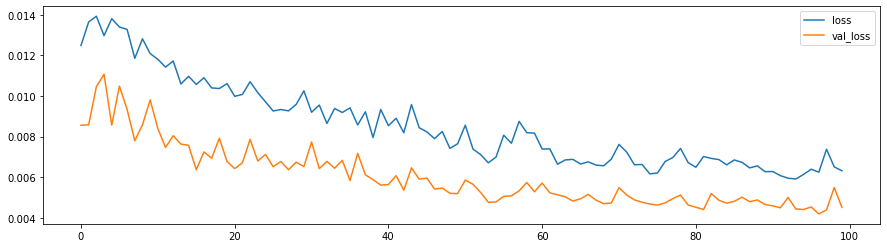

In [367]:
plt.figure(figsize = (15,4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

## Part 3 - Making the prediction and visualising the results

### Predict the stock prices

In [364]:
prediction = regressor.predict(x_test)

### Reverse normalization

In [365]:
prediction_transformed = sc.inverse_transform(prediction)

### Visualizing the results

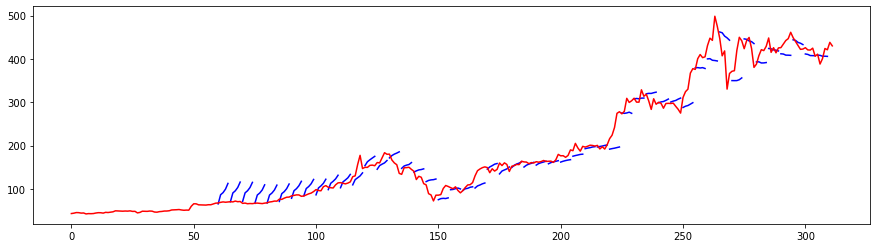

In [366]:
plt.figure(figsize=(15,4))
for i in range(timesteps, prediction_transformed.shape[0]+timesteps, days_ahead):
    x_index_seq = np.array(list(range(i, i+days_ahead))).reshape(-1,1)
    plt.plot(x_index_seq, prediction_transformed[i-timesteps], color = 'blue')


plt.plot(list(range(0, testing_set.shape[0])),testing_set, color = 'red', label = 'Real Tesla Stock Price')
#plt.legend()
plt.show()

# Part 4 - Exploring other possibilities

## Predicting based on the moving mean

In [229]:
days_ahead = 5
timesteps =  60
train_percentage = 0.8
moving_mean_days = 5

training_set, testing_set = split_timeserie_train_test(df_tesla[['Close']], train_percentage, timesteps)

addMovingMean(df_tesla, moving_mean_days)
training_set_mean, testing_set_mean = split_timeserie_train_test(df_tesla[['MovingMean' + str(moving_mean_days)]], train_percentage, timesteps)
training_set_mean = training_set[moving_mean_days-1:]


In [230]:
# Feature Scalling 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set_mean)
testing_set_scaled = sc.fit_transform(testing_set_mean)

x_train, y_train, x_test, y_test = split_timeserie_x_y(training_set_scaled, testing_set_scaled, timesteps, days_ahead)

#Reshaping to Keras
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

regressor = create_LSTM_architecture(units_firs = 128, units_headen = 64, units_output = days_ahead)

# Compilling the RNN to the Training set
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
30/30 [==============================] - 2s 64ms/step - loss: 0.0880
Epoch 2/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0258
Epoch 3/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0211
Epoch 4/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0200
Epoch 5/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0213
Epoch 6/100
30/30 [==============================] - 2s 67ms/step - loss: 0.0201
Epoch 7/100
30/30 [==============================] - 2s 83ms/step - loss: 0.0182
Epoch 8/100
30/30 [==============================] - 3s 87ms/step - loss: 0.0164: 1s
Epoch 9/100
30/30 [==============================] - 3s 91ms/step - loss: 0.0162
Epoch 10/100
30/30 [==============================] - 3s 90ms/step - loss: 0.0166
Epoch 11/100
30/30 [==============================] - 3s 86ms/step - loss: 0.0154
Epoch 12/100
30/30 [==============================] - 3s 87ms/step - loss: 0.0148
Epoch 13/100
30/30 [=

In [231]:
prediction = regressor.predict(x_test)
type(prediction)

prediction_transformed = sc.inverse_transform(prediction)
prediction_transformed.shape

(242, 10)

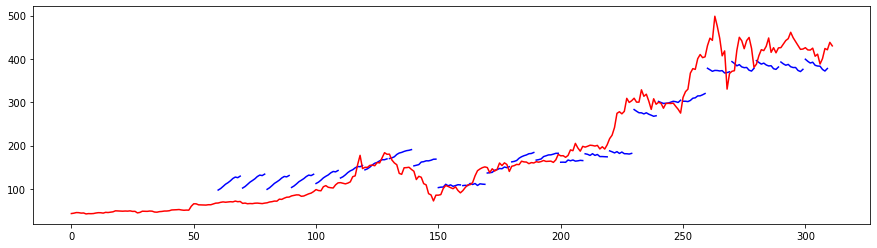

In [232]:
plt.figure(figsize=(15,4))
for i in range(timesteps, prediction_transformed.shape[0]+timesteps, days_ahead):
    x_index_seq = np.array(list(range(i, i+days_ahead))).reshape(-1,1)
    plt.plot(x_index_seq, prediction_transformed[i-timesteps], color = 'blue')


#plt.plot(list(range(0, testing_set.shape[0])),testing_set, color = 'red', label = 'Real Petrobras Stock Price')
plt.plot(list(range(0, testing_set.shape[0])),testing_set, color = 'red', label = 'Real Petrobras Stock Price')
#plt.legend()
plt.show()